In [92]:
pconnGrad = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/group-HCPS1200_atlas-GlasserTian_desc-subcorticalS2_conn.pconn.nii'

In [118]:
import nibabel as nib
from brainspace.gradient import GradientMaps
import pandas as pd
import numpy as np



def create_gradient(nifty, n, z_to_r):
    '''Create a pandas dataframe of n number of gradients from nifty file

    Loads .nii file with nibabel, creates a float type matrix
    Loads GradientMaps, and fits to the matrix
    Converts matrix to a pandas dataframe

    Parameters
    ----------
    nifty: .nii file type
        nifty file that will be read to create the gradients
    n: int
        The number of gradients to be created
    z_to_r: bool
        Determines whether hyperbolic tan is applied to the connectivity matrix

    Returns
    -------
    grad_df
        An array of values, rows x columns is ROIs x n number of gradients 

    ''' 

    # load the nii file with nibabel
    conn = nib.load(nifty)
    # create matrix with float data
    matrix = conn.get_fdata()
    # specify whether matrix converted to tanh matrix is true or false
    if z_to_r:
        matrix = np.tanh(matrix)
    # load GradientMaps
    gm = GradientMaps(n_components=n, random_state=0)
    # assert that the number of gradients requested does not exceed the regions of interest 
    max_grads = matrix.shape[0]
    assert n <= max_grads, 'Number of gradients exceeds rows in the matrix'
    # create the gradient as a matrix
    gm.fit(matrix)
    gradient = gm.gradients_
    # convert gradient to a pandas dataframe
    grad_df = pd.DataFrame(data = gradient, 
    columns=[f'grad{num + 1}' for num in range(gm.gradients_.shape[1])])
    return grad_df

grad_df = create_gradient(pconnGrad, 10, True)
grad_df

/home/a/arisvoin/lbassman/.conda/envs/nilearn_brainspace/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


,grad1,grad2,grad3,grad4,grad5,grad6,grad7,grad8,grad9,grad10
0,-0.459539,-0.593009,-1.190021,0.176420,-0.706088,0.983174,-0.446917,-1.094690,-0.008558,0.120105
1,-0.093351,0.098838,-0.833709,0.192058,-0.607272,0.466415,-0.282458,-1.412398,-0.380441,-0.584493
2,0.049237,0.053320,-1.484879,0.159870,1.540526,0.020441,-0.154830,-1.505156,0.826966,2.350844
3,-0.236359,-0.108027,-1.536074,0.031292,0.736398,0.425590,-0.244897,-1.389436,0.817537,2.153825
4,0.418004,0.720360,-0.357893,0.256709,-0.274612,-0.470230,0.037029,-0.620406,-0.479849,-0.747484
...,...,...,...,...,...,...,...,...,...,...
387,-1.021163,-0.835172,-1.192239,0.225827,0.347538,0.491257,-0.117368,0.627264,0.170071,-0.109201
388,-1.224417,-0.908553,0.224937,-0.605032,-0.089939,-0.664416,0.645081,0.452317,-0.248986,-0.403929
389,-0.022242,1.050746,-0.615233,0.443054,0.520173,-0.316245,-0.072517,-0.797091,-0.641586,0.166520
390,-0.560773,0.338905,0.931114,0.949999,-0.177031,-0.175830,-0.439192,0.076904,0.040172,0.201662


In [119]:
from pathlib import Path

def write_df_column_to_pscalar_nib(df, pscalar_template, 
        to_filename = None, columns = None, labelname_column = None):
    ''' write a column from a pandas dataframe to pscalar file in nibabel 
     Parameters
    ----------
    df: pandas DataFrame
        Pandas dataframe containing data to write to file (with rows as parcels)
    
    pscalar_template: nibabel.Cifti2Image or filepath
        A pscalar.nii or pterseries.nii file or image to read the parcel axis from
    
    to_filename: str or path
        (optional) path (with extension .pscalar.nii) to write the output to
    columns: str or list
        (optional) list of columns to select for the pscalar image
    labelnames_column: str
        (optional) name of column that contains labelnames that should match the pscalar parcel names
        If this is given than data will be merged/aligned with the parcel axis before writing file.
    
    Returns
    -------
    pscalar_img: nibabel.Cifti2Image
        nibabel image of the pscalar output
        '''
           ## read the parcel axis from a template file
    if isinstance(pscalar_template, (str, Path)):
        pscalar_template = nib.load(pscalar_template)
    template_axis = pscalar_template.header.get_index_map(1)
    axis1_parcels = nib.cifti2.cifti2_axes.ParcelsAxis.from_index_mapping(template_axis)
    assert (isinstance(axis1_parcels, nib.cifti2.cifti2_axes.ParcelsAxis)), "Did not creat parcel axis"

    if labelname_column:
        axis_df = pd.DataFrame({'labelnames': axis1_parcels.name})
        df = df.merge(axis_df, 
            left_on = labelname_column, right_on = 'labelnames', how = 'right')
    
    ## grab columns if they exist
    if columns:
        df = df[columns]

    # grab the data column(s) and resphape them to the shape for pscalar 
    ## note that the dataobj shape should be (n_map, n_parcels)
    data_vals = df.transpose().values
    if len(data_vals.shape) == 1:
        data_vals = np.reshape(data_vals, (1,data_vals.shape[0]))
    
    ## assert that the number of parcels matches the length of the data array
    assert (axis1_parcels.size == len(df.index)), 'The number of parcels does not match the number of rows'

    ## create a scalar axis with names inlcuding the column names
    axis0_scalars = nib.cifti2.cifti2_axes.ScalarAxis(name = df.columns)
    
    ## combine all the bits together
    new_header = nib.Cifti2Header.from_axes((axis0_scalars, axis1_parcels))
    pscalar_img = nib.Cifti2Image(
        dataobj=data_vals, header = new_header)
    if to_filename:
        nib.cifti2.save(
            img = pscalar_img,filename=to_filename)

    return(pscalar_img)

In [120]:
grad_image = write_df_column_to_pscalar_nib(grad_df, pconnGrad)

grad_image

In [121]:
nib.cifti2.save(
            img = grad_image,filename='HCP_grads.pscalar.nii')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


TypeError: colormap_from_ciftiheader() missing 1 required positional argument: 'dlabel_img'

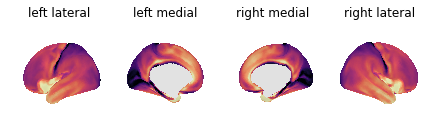

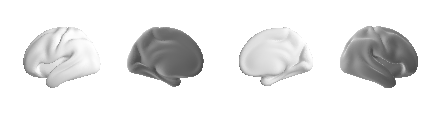

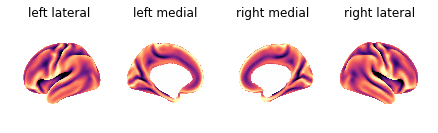

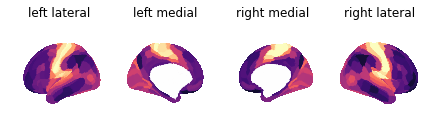

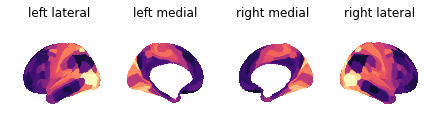

In [82]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
from enum import Enum
import nilearn.plotting as nplot
import nibabel as nib
from collections import namedtuple
import matplotlib.pyplot as plt
from pathlib import Path

CIFTI_GIFTI_MAP = {
    'CIFTI_STRUCTURE_CORTEX_LEFT': 'left',
    'CIFTI_STRUCTURE_CORTEX_RIGHT': 'right',
    'CortexLeft': 'left',
    'CortexRight': 'right'
}

NIFTI_INTENT_POINTSET = 1008


def gifti_get_mesh(gifti):
    '''
    Extract vertices and triangles from GIFTI surf.gii
    file
    Arguments:
        gifti (GiftiImage): Input GiftiImage
    '''

    v, t = gifti.agg_data(('pointset', 'triangle'))
    return v.copy(), t.copy()

def map_cifti_to_gifti(gifti, cifti, cifti_map_index = 0, fill_value = np.nan):
    '''
    Maps cifti data-array to gifti vertices to account
    for missing indices (i.e removal of medial wall)
    Arguments:
        gifti:      GIFTI surface mesh
        cifti:      CIFTI file to map [Series x BrainModel]
    Returns:
        verts:          Vertices of surface mesh
        trigs:          Triangles of surface mesh
        mapping_array:  An [Features x Vertices] mapping array pulled
                        from the CIFTI image
    '''

    # Validate and obtain CIFTI indices
    brain_models = None
    parcels = None
    for mi in cifti.header.mapped_indices:
        map_type = cifti.header.get_index_map(mi).indices_map_to_data_type
        if map_type == "CIFTI_INDEX_TYPE_BRAIN_MODELS":
            brain_models = cifti.header.get_axis(mi)
        if map_type == "CIFTI_INDEX_TYPE_PARCELS":
            parcels = cifti.header.get_axis(mi)

    # TODO: Implement logging + proper error
    if (brain_models is None) and (parcels is None):
        raise ValueError("CIFTI object does not contain BrainModelAxis!")

    # Validate and obtain GIFTI
    gifti_struct = None
    for d in gifti.darrays:
        if d.intent == NIFTI_INTENT_POINTSET:
            try:
                gifti_struct = d.metadata['AnatomicalStructurePrimary']
            except KeyError:
                raise ValueError(
                    f"{gifti.get_filename()} is not a surface mesh file!")

    if gifti_struct is None:
        raise ValueError(
            f"{gifti.get_filename()} contains no coordinate information!")

    # Now we need to map the coordinate of CIFTI onto GIFTI
    match_key = CIFTI_GIFTI_MAP[gifti_struct]
    
    # Extract vertices from GIFTI
    verts, trigs = gifti_get_mesh(gifti)
    
    for stucture in ['CIFTI_STRUCTURE_CORTEX_LEFT', 'CIFTI_STRUCTURE_CORTEX_RIGHT']:
        if CIFTI_GIFTI_MAP[stucture] == match_key:
            if parcels:
                mapping_array = surf_map_from_pscalar_image(cifti, 
                                                            stucture, 
                                                            map = cifti_map_index, 
                                                            fill_value = fill_value)
            if brain_models:
                mapping_array = surf_data_from_dense_cifti(cifti, 
                                                          stucture,
                                                          map_index = cifti_map_index,
                                                          fill_value = fill_value)
                
    
#     matched_bm = None
#     for struct, sl, bma in brain_models.iter_structures():
#         if CIFTI_GIFTI_MAP[struct] == match_key:
#             matched_bm = (struct, sl, bma)
#             break       
            
#     if matched_bm is None:
#         raise ValueError(
#             "No matching structures between CIFTI and GIFTI file!")

#     _, matched_verts, brain_model_ax = matched_bm
#     cifti_verts = brain_model_ax.vertex

#     # Map CIFTI vertices to GIFTI, setting non-filled values to NaN
#     mapping_array = np.empty((cifti.dataobj.shape[0], verts.shape[0]),
#                              dtype=cifti.dataobj.dtype)

#     # Write NaNs
#     mapping_array[:] = np.nan
#     try:
#         mapping_array[:, cifti_verts] = cifti.get_fdata()[:, matched_verts]
#     except IndexError:
#         raise ValueError("Cifti file contains vertices that are not indexed "
#                          "by the provided gifti file!")

    # Return mapping array
    return verts, trigs, mapping_array


# In[2]:


def surf_data_from_dense_cifti(cifti, surf_name, map_index = "all", fill_value = np.nan):
    # the dscalar img is a filepath - load it
    if isinstance(cifti, (str, Path)):
        cifti = nib.load(cifti)
    axis = cifti.header.get_axis(1)
    data = cifti.get_fdata()
    if not map_index == "all":
        data = data[map_index,:]
    assert isinstance(axis, nib.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[:] = fill_value
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")


# In[3]:


pconn = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/group-HCPS1200_atlas-GlasserTian_desc-subcorticalS2_conn.pconn.nii'


# In[4]:


def surf_map_from_pscalar_image(pscalar_img, surface, map = 0, fill_value = np.nan):
    '''
    Read data from parcellated scalar or parcellated timeseries image into full surface map for plotting
    
    Parameters
    ----------
    pscalar_img: nibabel image, str or path
        nibabel image or filepath to image with extension .pscalar.nii
    
    surface: str
        Surface to load (either CIFTI_STRUCTURE_CORTEX_LEFT or CIFTI_STRUCTURE_CORTEX_RIGHT)
    
    map: str or integer
        Either the name of the scalar map or the column index (default: 0)
    fill_value: numeric value
        value to fill missing data non-parcel vertices on the surfuce (default: np.nan)
    Return
    ------
    surf_out: numpy data array (nvertices,)
        the parcellated scalar data mapped to the surface
    '''
    
    # the pscalar img is a filepath - load it
    if isinstance(pscalar_img, (str, Path)):
        pscalar_img = nib.load(pscalar_img)
    
    ## define map_number based on the "map" input arg
    if isinstance(map, str):
        if map == "all":
            map_number = list(range(len(pscalar_img.header.get_axis(1).name)))
        else:
            map_number = np.where(pscalar_img.header.get_axis(0).name==map)[0]
            if len(map_number) != 1:
                raise ValueError(f"the map name {map} was not present in the scalar axis names")
            map_number = int(map_number[0])
    else: 
        map_number = int(map)

    # grab the data
    data = pscalar_img.get_fdata()[map_number,:]
    if len(data.shape) == 1:
      data = data.reshape(data.shape[0],1)

    # grab the parcel axis (axis 1)
    axis = pscalar_img.header.get_axis(1)
    assert isinstance(axis, nib.cifti2.ParcelsAxis)

    # intialize an output array
    surf_out = np.zeros((axis.nvertices[surface], data.shape[1]))
    surf_out[:] = fill_value

    # iterate over the parcels writing the parcel values to the vertex indices
    for (parcel_data, parcel_vertices) in zip(data, axis.vertices):
        if surface in parcel_vertices:
            surf_out[parcel_vertices[surface],:] = parcel_data
    
    return surf_out


# In[142]:


import pandas as pd
from matplotlib.colors import ListedColormap


def colormap_from_ciftiheader(dlabel_img):
    ''' reads the colormap from the cifti image LabelAxis for dense labels files (dlabel.nii)
    
    Parameters
    ----------
    dlabel_image: str, path or nibabel.cifti2 image
        input label file or image
        
    Returns
    -------
    cm : matplotlib colormap
        matplotlib colormap object read with the color look up table colours
    '''
    if isinstance(dlabel_img, (str, Path)):
            dlabel_img = nib.load(dlabel_img)
        # read the labeltable from the header
    label_axis = dlabel_img.header.get_axis(0)
    assert isinstance(label_axis, nib.cifti2.cifti2_axes.LabelAxis)
    label_colours = [val[1] for val in label_axis.label[0].values()]
    cm = ListedColormap(
        name = label_axis.name[0], 
        colors = label_colours, 
        N=max(label_axis.label[0].keys())+1)
    return cm


# In[143]:



    
def plot_cifti_surf_montage(left_surf, right_surf, cifti_map, 
                            bg_cifti_map = None, 
                            views = ["lateral", "medial", "medial", "lateral"],
                            hemis = ["left", "left", "right", "right"],
                            bg_cifti_map_index = "all", 
                            colormap = None, 
                            darkness = 0.8,
                            add_view_titles = True,
                            to_filename = None):
    """
    plotting montage of both hemispheres
    
    Generate a surface visualization
    Parameters
    --------
    left_surf: str or Path
      
    bg_cifti_map :
      (optional) Cifti file containing background map data (usually sulci depth)
    Returns:
        runtime: Resultant runtime object
    """

    from mpl_toolkits import mplot3d  # noqa: F401

    assert len(views) == len(hemis), f"number of views ({views}) is not equal to the number of hemipheres ({hemis})"
        
    Hemispheres = namedtuple("Hemispheres", ["left", "right"])
    vmin = None
    vmax = None

    l_surf = nib.load(left_surf)
    r_surf = nib.load(right_surf)
    num_views = len(views)
    num_maps = 1

    if cifti_map:
        cifti_map = nib.load(cifti_map)
        lv, lt, lm = map_cifti_to_gifti(l_surf, cifti_map, cifti_map_index = bg_cifti_map_index)
        rv, rt, rm = map_cifti_to_gifti(r_surf, cifti_map, cifti_map_index = bg_cifti_map_index)

        map_hemi = Hemispheres(left=(lv, lt, lm), right=(rv, rt, rm))
        num_maps = lm.shape[1]
        
        if colormap == "read_from_cifti":
            colormap = colormap_from_ciftiheader(cifti_map)
        else:
            vmin, vmax = np.nanpercentile(cifti_map.get_fdata(), [2, 98])
    else:
        # Use vertices and triangles from Mesh
        lv, lt = gifti_get_mesh(l_surf)
        rv, rt = gifti_get_mesh(r_surf)
        map_hemi = Hemispheres(left=(lv, lt, None), right=(rv, rt, None))
        

    if bg_cifti_map:
        bg_map = nib.load(bg_cifti_map)
        _, _, l_bg = map_cifti_to_gifti(l_surf, bg_map, fill_value = 0)
        _, _, r_bg = map_cifti_to_gifti(r_surf, bg_map, fill_value = 0)
        bg_hemi = Hemispheres(left=l_bg, right=r_bg)
    else:
        bg_hemi = Hemispheres(left=None, right=None)

    # Construct figure
    w, h = plt.figaspect(num_maps / (num_views))
    fig, axs = plt.subplots(num_maps,
                            num_views,
                            subplot_kw={'projection': '3d'},
                            figsize=(w, h))
    fig.set_facecolor("white")
    fig.tight_layout()
    for i, a in enumerate(axs.flat):
        a.set_facecolor("white")

        # Get row (map)
        i_map = i // (num_views)

        # Get column
        i_view = (i) % (num_views)
        view = views[i_view]

        # Get hemisphere
        hemi = hemis[i_view]
        if hemi == "left":
            display_map = map_hemi.left
            display_bg = bg_hemi.left
        elif hemi == "right":
            display_map = map_hemi.right
            display_bg = bg_hemi.right
        else:
            raise ValueError('hemis must be "left" or "right"')
        
        if add_view_titles: a.set_title(f'{hemi} {view}')
        # Plot
        v, t, m = display_map
        nplot.plot_surf([v, t],
                        surf_map=m,
                        bg_map= display_bg,
                        cmap=colormap,
                        axes=a,
                        hemi=hemi,
                        view=view,
                        bg_on_data=True,
                        vmin = vmin,
                        vmax = vmax,
                        darkness=darkness)
    
    if not to_filename:    
        plt.draw()
    else:
        plt.savefig(to_filename)
    
    return(plt)
    


# In[130]:


#get_ipython().system(' ls scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR')


# In[126]:


get_ipython().run_line_magic('matplotlib', 'inline')


# In[134]:


pl3 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii', 
                        bg_cifti_map = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii',  
                        colormap = "magma", 
                        darkness = 0.2,
                        to_filename = None)


# In[132]:


pl3 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = None, 
                        bg_cifti_map = None, 
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None,
                        add_view_titles = False)


# In[30]:


plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii', 
                        bg_cifti_map = None, 
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None)


# In[31]:


plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = pconn, 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 40,
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None)


# In[33]:


plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = pconn, 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 'L_MST_ROI',
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None)




dlabel_file = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR_den-32k_atlas-Glasser2016Tian2019_desc-subcortexS2_dseg.dlabel.nii'


# In[121]:


label_axis = nib.load(dlabel_file).header.get_axis(0)
label_colours = [val[1] for val in label_axis.label[0].values()]
label_keys = label_axis.label[0].keys()


# In[122]:


max(label_keys)


# In[105]:


# %%
from matplotlib.colors import ListedColormap
cm = colormap_from_ciftiheader()

# %%
import matplotlib.pyplot as plt
x = np.array(list(label_keys))
y = np.ones(len(label_colours)) 

plt.figure(figsize=(20,1))
plt.scatter(x, y, marker='o', s = 100, c=x, cmap = cm)

# Show the boundary between the regions:
plt.show()


# In[108]:


lv, lt, lm = map_cifti_to_gifti(nib.load('/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii'), 
                                nib.load(dlabel_file), cifti_map_index = "all")


# In[118]:


label_axis.name[0]


# In[144]:


plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = dlabel_file, 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = "all",
                        colormap = "read_from_cifti", 
                        darkness = 0,
                        to_filename = None)


# In[155]:


yeo_cm = colormap_from_ciftiheader('/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR_den-32k_atlas-Ji2019_desc-12net_dseg.dlabel.nii')
x = np.array(range(14))
y = np.ones(14) 

plt.figure(figsize=(20,1))
plt.scatter(x, y, marker='o', s = 100, c=x, cmap = yeo_cm)

# Show the boundary between the regions:
plt.show()


# In[153]:


plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR_den-32k_atlas-Ji2019_desc-12net_dseg.dlabel.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = "all",
                        colormap = "read_from_cifti", 
                        darkness = 0,
                        to_filename = None)


# In[11]:



surf_map_from_pscalar_image(pconn, "CIFTI_STRUCTURE_CORTEX_LEFT", map = 'aHIP-rh', fill_value = np.nan).shape


# In[ ]:


cifti_map = 'HCP_grads.pscalar.nii'
dcifti = nib.load(cifti_map)


# In[ ]:


ddata = surf_data_from_dense_cifti(dcifti, "CIFTI_STRUCTURE_CORTEX_LEFT", map_index = "all", fill_value = np.nan)


# In[19]:


views = ['medial']
num_views = len(views)
num_maps = 2
mirror_views = True

if mirror_views == True:
    all_views = views + views[::-1]
else:
    all_views = views*2
    
w, h = plt.figaspect(num_maps / (num_views * 2))
fig, axs = plt.subplots(num_maps,
                        len(all_views),
                        subplot_kw={'projection': '3d'},
                        figsize=(w, h))
for i, a in enumerate(axs.flat):

        # Get row (map)
        i_map = i // len(all_views)

        # Get column
        i_view = (i) % len(all_views)
        #i_view = (i // (i_map + 1)) % num_views
        view = all_views[i_view]

        # Get hemisphere
        hemi = i_view // num_views
        if hemi == 0:
            hemi = "left"
        else:
            hemi = "right"
        print(f'{i} row/colum: {i_map}/{i_view} {view} {hemi}')

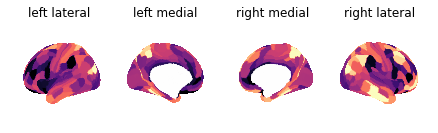

In [97]:
# In[33]:


plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'HCP_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 12,
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None)


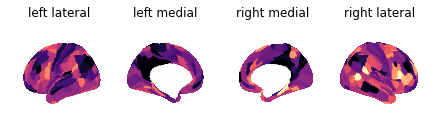

In [113]:
from scipy.spatial import procrustes
import pandas as pd

conntwo = pd.read_csv(r'/scratch/a/arisvoin/edickie/SPINS_glasser_tian/2mm_noGSR/sub-CMH0001/sub-CMH0001_RS_2mm_noGSR_glasser_tian_meants.csv', header = None)

imagetwo = write_df_column_to_pscalar_nib(conntwo, pconnGrad)
nib.cifti2.save(
            img = imagetwo,filename='participant_grad.pscalar.nii')

plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'participant_grad.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 12,
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None)

partgrad_df = pd.DataFrame(data = conntwo)

In [109]:
gp = GradientMaps(kernel='normalized_angle', alignment='procrustes')


gref = GradientMaps(kernel='normalized_angle', approach='le')
gref.fit(conn_matrix2)

galign = GradientMaps(kernel='normalized_angle', approach='le', alignment='procrustes')
galign.fit(conn_matrix, reference=gref.gradients_)

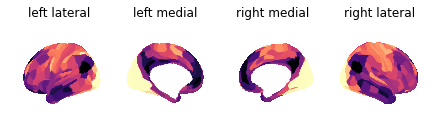

In [124]:
import nibabel as nib
from brainspace.gradient import GradientMaps
import pandas as pd
import numpy as np



def calc_aligned_gradient(input_timeseries, template_gradients, kernel = 'cosine', alignment = 'procrustes'):
    '''Create a pandas dataframe of n number of gradients from nifty file

    Loads .nii file with nibabel, creates a float type matrix
    Loads GradientMaps, and fits to the matrix
    Converts matrix to a pandas dataframe

    Parameters
    ----------
    !!input_timeseries (ndarray or list of arrays, shape = (n_ROIs, n_timepoints))
    !!template_gradients, shape =  (n_rois, n_gradients)


    Returns
    -------
    grad_df
        An array of values, rows x columns is ROIs x n number of gradients 

    ''' 
    # load GradientMaps
    gm = GradientMaps(n_components=template_gradients.shape[1], random_state=0, alignment = 'procrustes', kernel=kernel)
    # assert that the number of gradients requested does not exceed the regions of interest 
    #max_grads = matrix.shape[0]
    #assert n <= max_grads, 'Number of gradients exceeds rows in the matrix'
    # create the gradient as a matrix
    gm.fit(input_timeseries, reference = template_gradients)
    gradient = gm.aligned_
    # convert gradient to a pandas dataframe
    grad_df_aligned = pd.DataFrame(data = gradient, 
    columns=[f'grad{num + 1}' for num in range(gm.aligned_.shape[1])])
    return grad_df_aligned

aligned_gradient = calc_aligned_gradient(conntwo.values, grad_df.values)

aligned_pscalar = write_df_column_to_pscalar_nib(aligned_gradient, pconnGrad, to_filename= 'aligned_grads.pscalar.nii')

plt2 = plot_cifti_surf_montage(left_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        right_surf = '/scratch/a/arisvoin/edickie/SPINS_glasser_tian/tpl-fsLR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii', 
                        cifti_map = 'aligned_grads.pscalar.nii', 
                        bg_cifti_map = None, 
                        bg_cifti_map_index = 0,
                        colormap = "magma", 
                        darkness = 0,
                        to_filename = None)


In [126]:
!ls /scratch/a/arisvoin/edickie/SPINS_glasser_tian/2mm_noGSR/sub-CMH0001


sub-CMH0001_circles.1D	sub-CMH0001_EA_2mm_noGSR_glasser_tian_meants.csv
sub-CMH0001_EA.1D	sub-CMH0001_RS_2mm_noGSR_glasser_tian_meants.csv


In [127]:
!ls /scratch/a/arisvoin/edickie/SPINS_glasser_tian/2mm_noGSR

sub-CMH0001  sub-CMH0106  sub-CMP0196  sub-MRC0063  sub-MRP0156  sub-ZHP0088
sub-CMH0002  sub-CMH0107  sub-CMP0198  sub-MRC0064  sub-MRP0157  sub-ZHP0091
sub-CMH0003  sub-CMH0109  sub-CMP0199  sub-MRC0065  sub-MRP0158  sub-ZHP0093
sub-CMH0004  sub-CMH0110  sub-CMP0201  sub-MRC0066  sub-MRP0159  sub-ZHP0094
sub-CMH0005  sub-CMH0111  sub-CMP0202  sub-MRC0068  sub-MRP0160  sub-ZHP0095
sub-CMH0007  sub-CMH0113  sub-CMP0203  sub-MRC0069  sub-MRP0162  sub-ZHP0096
sub-CMH0008  sub-CMH0114  sub-CMP0205  sub-MRC0070  sub-MRP0164  sub-ZHP0097
sub-CMH0009  sub-CMH0117  sub-CMP0206  sub-MRC0071  sub-MRP0165  sub-ZHP0098
sub-CMH0011  sub-CMH0118  sub-CMP0207  sub-MRC0072  sub-MRP0166  sub-ZHP0099
sub-CMH0012  sub-CMH0119  sub-CMP0209  sub-MRC0073  sub-ZHH0001  sub-ZHP0100
sub-CMH0013  sub-CMH0120  sub-CMP0211  sub-MRC0074  sub-ZHH0002  sub-ZHP0101
sub-CMH0014  sub-CMH0123  sub-CMP0213  sub-MRP0019  sub-ZHH0003  sub-ZHP0102
sub-CMH0015  sub-CMH0125  sub-CMP0215  sub-MRP0067  sub-ZHH0004  sub-ZHP0103